# Data imputation
[TOC]

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from mlens.visualization import pca_comp_plot
from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)

def fill_dataset(dataset, feature, filled_feature, save_path):
    filled_dataset = dataset.copy()
    filled_dataset[feature] = filled_feature
    filled_dataset.to_csv(save_path, index=None)
    return filled_dataset

def get_models():
    nb = GaussianNB()
    svc = SVC(kernel='rbf', C=100, gamma=1e-3, probability=True, class_weight='balanced')
    knn = KNeighborsClassifier(n_neighbors=8)
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((32, 64, 16), solver='lbfgs', activation='relu', random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=64, random_state=seed)
    rf = RandomForestClassifier(n_estimators=64, max_features=2, random_state=seed)
    ab = AdaBoostClassifier(n_estimators=64, random_state=seed)
    xgb = XGBClassifier(random_state=seed)        
    models = {'svm': svc, 
              'knn': knn, 
              'naive bayes': nb,
              'mlp': nn,
              'random forest': rf,
              'gradient boost': gb,
              'logistic': lr,
              'adaboost': ab,
              'xgboost': xgb, 
             }
    return models

def sensitivity_specificity(cm):
    return cm[1, 1] / np.sum(cm[1]), cm[0, 0] / np.sum(cm[0])

def get_severity(Prognosis):
    if Prognosis == 'MILD':
        return 0
    elif Prognosis == 'SEVERE':
        return 1

def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            print('no sample weight')
            m.fit(x_train, y_train)
        try:
            print('\n', name, m.feature_importances_)
        except:
            print('no feature importances')
        P.iloc[:, i] = m.predict_proba(x_test)[:, 1]
        cols.append(name)
        print("done")
    
    P.columns = cols
    print("Done.\n")
    return P

def cross_val_models(model_list, cv=5, scoring='accuracy'):
    P = np.zeros((cv, len(model_list)))
    P = pd.DataFrame(P)

    print('Fitting models...')
    cols = list()
    for i, (name, m) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        P.iloc[:, i] = cross_val_score(m, X, y, cv=cv, scoring=scoring)
        cols.append(name)
        print("done")
    P.columns = cols
    print('Done.\n')
    return P

def cross_val_acc(P, scoring='ACC'):
    for m in P.columns:
        score = np.mean(P.loc[:, m])
        std = 2 * np.std(P.loc[:, m])
        print('{} {} Result {} +/- {}'.format(m, scoring, score, std))

def score_models(P, y):
    print('ROC AUC SCORE')
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print('ACC SCORE')
    for m in P.columns:
        score = accuracy_score(y, np.float32(P.loc[:, m]>=0.5))
        print("%-26s: %.3f" % (m, score))

def plot_roc_curve(y_test, P_base_learners, P_ensemble, labels, ens_label):
    plt.plot([0, 1], [0, 1], 'k--')
    #cm = [plt.cm.gray(i) for i in np.linspace(0, 1.0, P_base_learners.shape[1])]
    cm = sns.color_palette("Blues", P_base_learners.shape[1])
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i])
        
    fpr, tpr, _ = roc_curve(y_test, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c='red')
    
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
def train_base_learners(base_learners, x_train, y_train):
    print('Fitting models')
    feature_importances = {}
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        try:
            m.fit(x_train, y_train, sample_weight=get_sample_weight(y_train))
        except:
            m.fit(x_train, y_train)
            print('no sample_weight')
        try:
            feature_importances.update({name: m.feature_importances_})
        except:
            print('no feature importances')
    print('done.')
    return feature_importances

def predict_base_learners(base_learners, x):
    P = np.zeros((x.shape[0], len(base_learners)))
    print('Generating base learner predictions.')
    for i, (name, m) in enumerate(base_learners.items()):
        print('%s...'% name, end='', flush=False)
        p = m.predict_proba(x)
        P[:, i] = p[:, 1]
    print('done.')
    return P

def ensemble_predict(base_learners, meta_learner, x):
    P_pred = predict_base_learners(base_learners, x)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

Using TensorFlow backend.
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

## Read data

In [2]:
train_data_path = './trainSet/trainSet.txt'
test_data_path = './testSet/testSet.txt'

In [3]:
train_dataset = pd.read_csv(train_data_path, sep=',')
train_dataset['severity'] = train_dataset['Prognosis'].map(get_severity)
test_dataset = pd.read_csv(test_data_path, sep=',')

feature = [
    'Age', 
    'Sex', 
    'Temp_C', 
    'Cough', 
    'DifficultyInBreathing', 
    'WBC', 
    'CRP',
    'Fibrinogen', 
    'LDH',
    'Ddimer', 
    'Ox_percentage',
    'PaO2', 
    'SaO2',
    'pH',
    'CardiovascularDisease',
    'RespiratoryFailure',
]

y = np.array(train_dataset['severity'])

## Imputation
### Impute testing dataset
- Filled NaN data using [method] based on concatenation of trainSet.txt & testSet.txt.
- There are columns filled with **NaN** so we need **concatenation** of trainSet.txt & testSet.txt, otherwise nothing meaningful imputation can be obtained.

In [4]:
concat_feature = pd.concat([test_dataset[feature], train_dataset[feature]])
test_dataset_len = len(test_dataset)
train_dataset_len = len(train_dataset)

In [5]:
X_incomplete = concat_feature
X_incomplete = np.array(X_incomplete)

X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

test_dataset_filled_knn_3 = fill_dataset(test_dataset, feature, X_filled_knn_3[:test_dataset_len], './csv/filled_testSet/filled_knn_3_testSet.txt')
test_dataset_filled_knn_6 = fill_dataset(test_dataset, feature, X_filled_knn_6[:test_dataset_len], './csv/filled_testSet/filled_knn_6_testSet.txt')
test_dataset_filled_knn_9 = fill_dataset(test_dataset, feature, X_filled_knn_9[:test_dataset_len], './csv/filled_testSet/filled_knn_9_testSet.txt')
test_dataset_filled_softimpute = fill_dataset(test_dataset, feature, X_filled_softimpute[:test_dataset_len], './csv/filled_testSet/filled_softimpute_testSet.txt')

Imputing row 1/983 with 4 missing, elapsed time: 0.173
Imputing row 101/983 with 9 missing, elapsed time: 0.182
Imputing row 201/983 with 4 missing, elapsed time: 0.188
Imputing row 301/983 with 6 missing, elapsed time: 0.193
Imputing row 401/983 with 3 missing, elapsed time: 0.198
Imputing row 501/983 with 1 missing, elapsed time: 0.203
Imputing row 601/983 with 3 missing, elapsed time: 0.208
Imputing row 701/983 with 4 missing, elapsed time: 0.213
Imputing row 801/983 with 3 missing, elapsed time: 0.218
Imputing row 901/983 with 1 missing, elapsed time: 0.223
Imputing row 1/983 with 4 missing, elapsed time: 0.169
Imputing row 101/983 with 9 missing, elapsed time: 0.180
Imputing row 201/983 with 4 missing, elapsed time: 0.185
Imputing row 301/983 with 6 missing, elapsed time: 0.189
Imputing row 401/983 with 3 missing, elapsed time: 0.195
Imputing row 501/983 with 1 missing, elapsed time: 0.199
Imputing row 601/983 with 3 missing, elapsed time: 0.204
Imputing row 701/983 with 4 missing

In [6]:
### Impute training dataset

In [7]:
X_incomplete = train_dataset[feature]
X_incomplete = np.array(X_incomplete)

In [8]:
X_filled_knn_3 = KNN(k=3).fit_transform(X_incomplete)
X_filled_knn_6 = KNN(k=6).fit_transform(X_incomplete)
X_filled_knn_9 = KNN(k=9).fit_transform(X_incomplete)

# Not suitable for large scale matrix
# X_filled_nnm = NuclearNormMinimization().fit_transform(X_incomplete)

X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete_normalized)

fill_dataset(train_dataset, feature, X_filled_knn_3, './csv/filled_trainSet/filled_knn_3_trainSet.txt')
fill_dataset(train_dataset, feature, X_filled_knn_6, './csv/filled_trainSet/filled_knn_6_trainSet.txt')
fill_dataset(train_dataset, feature, X_filled_knn_9, './csv/filled_trainSet/filled_knn_9_trainSet.txt')
fill_dataset(train_dataset, feature, X_filled_softimpute, './csv/filled_trainSet/filled_softimpute_trainSet.txt')

Imputing row 1/863 with 4 missing, elapsed time: 0.127
Imputing row 101/863 with 1 missing, elapsed time: 0.132
Imputing row 201/863 with 2 missing, elapsed time: 0.136
Imputing row 301/863 with 3 missing, elapsed time: 0.141
Imputing row 401/863 with 5 missing, elapsed time: 0.145
Imputing row 501/863 with 3 missing, elapsed time: 0.150
Imputing row 601/863 with 4 missing, elapsed time: 0.154
Imputing row 701/863 with 2 missing, elapsed time: 0.159
Imputing row 801/863 with 2 missing, elapsed time: 0.164
Imputing row 1/863 with 4 missing, elapsed time: 0.127
Imputing row 101/863 with 1 missing, elapsed time: 0.132
Imputing row 201/863 with 2 missing, elapsed time: 0.137
Imputing row 301/863 with 3 missing, elapsed time: 0.142
Imputing row 401/863 with 5 missing, elapsed time: 0.148
Imputing row 501/863 with 3 missing, elapsed time: 0.152
Imputing row 601/863 with 4 missing, elapsed time: 0.157
Imputing row 701/863 with 2 missing, elapsed time: 0.162
Imputing row 801/863 with 2 missing

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,...,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis,severity
0,P_131,P_131.png,D,-2.048085,-0.470271,2.071065,1.184345,-0.727476,-0.282021,0.345562,...,0.434853,-0.783510,0.135770,-0.145223,0.149724,0.103948,-0.338072,0.031417,MILD,0
1,P_132,P_132.png,D,-0.573848,-0.863055,-0.816018,-1.273968,-1.161819,2.441516,1.088330,...,0.026035,-0.514003,0.132170,0.331484,1.016130,-0.140048,-0.754792,0.001973,MILD,0
2,P_195,P_195.png,D,1.028030,-1.239311,-0.090446,0.339837,-1.451119,-0.240271,2.120167,...,0.156294,-0.505286,0.043121,-0.481180,0.236678,-1.799867,1.088011,-0.602686,SEVERE,1
3,P_193,P_193.png,D,0.957637,-1.085143,0.040121,0.174346,-1.249956,0.111873,2.358340,...,0.892093,0.320076,0.502719,-0.147390,0.458463,-1.404419,-1.112501,-0.564169,SEVERE,1
4,P_140,P_140.png,D,-0.281839,1.999293,-0.838134,1.319373,-1.172434,-0.082333,-0.366265,...,-0.380354,-0.961632,-0.133020,0.295323,1.230242,-0.007396,-0.713251,0.084275,MILD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,P_1_12,P_1_12.png,F,-0.594417,-0.771100,0.121812,-0.957951,0.401711,1.926319,-0.143749,...,0.168422,1.916612,0.099099,0.270480,0.070771,-0.472191,-0.768774,-0.946399,SEVERE,1
859,P_1_8,P_1_8.png,F,-0.626298,-0.752838,0.087955,1.351837,-1.073417,-0.732451,-0.766275,...,1.229788,-0.140530,-0.084498,-0.149238,0.001026,0.109509,-0.611901,0.253364,SEVERE,1
860,P_1_10,P_1_10.png,F,-1.835094,-0.157819,-0.129995,-0.536102,1.657106,0.404006,-0.818715,...,-0.132407,-0.052221,-0.072316,-0.103225,-0.133353,0.725543,0.020718,1.318122,MILD,0
861,P_1_26,P_1_26.png,F,1.525938,0.664581,0.118593,-1.175948,0.444988,2.047290,-0.559290,...,0.138736,0.596373,-0.034877,0.226006,0.086712,-1.463690,-0.958878,-1.223870,SEVERE,1


## Clinical data prediction
Select **imputation** method you want to verify here.

In [9]:
# X = X_filled_knn_3.copy()
# X = X_filled_knn_6.copy()
# X = X_filled_knn_9.copy()
X = X_filled_softimpute.copy()

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=linear as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass kernel=rbf as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


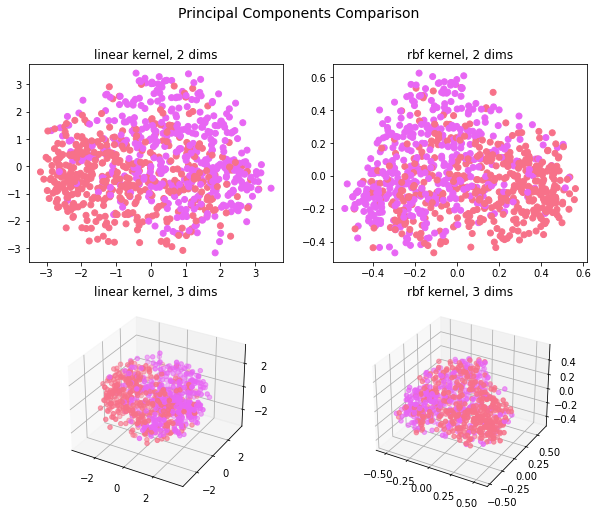

[<AxesSubplot:title={'center':'linear kernel, 2 dims'}>,
 <AxesSubplot:title={'center':'rbf kernel, 2 dims'}>,
 <Axes3DSubplot:title={'center':'linear kernel, 3 dims'}>,
 <Axes3DSubplot:title={'center':'rbf kernel, 3 dims'}>]

In [10]:
pca_comp_plot(X, y)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print('样本集大小：',X.shape,y.shape)
print('训练集大小：',x_train.shape,y_train.shape)  # 训练集样本大小
print('测试集大小：',x_test.shape,y_test.shape)  # 测试集样本大小

样本集大小： (863, 16) (863,)
训练集大小： (690, 16) (690,)
测试集大小： (173, 16) (173,)


In [12]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models...
svm... no sample weight
no feature importances
done
knn... no sample weight
no feature importances
done
naive bayes... no sample weight
no feature importances
done
mlp... no sample weight
no feature importances
done
random forest... no sample weight

 random forest [0.07237513 0.06200036 0.04445395 0.0509426  0.05141474 0.0454205
 0.08053085 0.05781409 0.10820072 0.05347902 0.07868684 0.06135261
 0.09472812 0.0468866  0.04541476 0.04629914]
done
gradient boost... no sample weight

 gradient boost [0.07743489 0.05785279 0.01815878 0.02429884 0.04939829 0.02094176
 0.09885597 0.02826301 0.3149959  0.00719196 0.11875747 0.06761731
 0.06581314 0.01584081 0.01344497 0.0211341 ]
done
logistic... no sample weight
no feature importances
done
adaboost... no sample weight

 adaboost [0.046875 0.109375 0.046875 0.03125  0.046875 0.015625 0.046875 0.046875
 0.21875  0.046875 0.078125 0.09375  0.0625   0.03125  0.046875 0.03125 ]
done
xgboost... no sample weight

 xgboost [0.04611

In [13]:
models = get_models()
cv_results=cross_val_models(models)
cross_val_acc(cv_results)

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ACC Result 0.7427745664739884 +/- 0.05440031600438717
knn ACC Result 0.7404288210781018 +/- 0.035786046028441536
naive bayes ACC Result 0.7404557064121522 +/- 0.024088119055839404
mlp ACC Result 0.687135367656943 +/- 0.0670357325539444
random forest ACC Result 0.746276381234037 +/- 0.03578372313603957
gradient boost ACC Result 0.7520500067213336 +/- 0.057174556450723696
logistic ACC Result 0.7427812878075011 +/- 0.05754105944888168
adaboost ACC Result 0.7231146659497244 +/- 0.04761334972619844
xgboost ACC Result 0.7369942196531791 +/- 0.04308839273015


In [14]:
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost
0,0.751445,0.757225,0.745665,0.734104,0.739884,0.728324,0.739884,0.710983,0.722543
1,0.710983,0.751445,0.734104,0.699422,0.728324,0.751445,0.699422,0.699422,0.734104
2,0.751445,0.722543,0.728324,0.630058,0.734104,0.757225,0.768786,0.710983,0.728324
3,0.715116,0.715116,0.732558,0.686047,0.750000,0.720930,0.726744,0.726744,0.720930
4,0.784884,0.755814,0.761628,0.686047,0.779070,0.802326,0.779070,0.767442,0.779070


In [15]:
cv_results_roc=cross_val_models(models, scoring='roc_auc')
cross_val_acc(cv_results_roc, scoring='ROC AUC')

Fitting models...
svm... done
knn... done
naive bayes... done
mlp... done
random forest... done
gradient boost... done
logistic... done
adaboost... done
xgboost... done
Done.

svm ROC AUC Result 0.8243874854016842 +/- 0.045603908682953706
knn ROC AUC Result 0.8001836314463089 +/- 0.05007968592050123
naive bayes ROC AUC Result 0.823598561681726 +/- 0.04396751544029637
mlp ROC AUC Result 0.7223166758866556 +/- 0.06794080280268501
random forest ROC AUC Result 0.8253654188948307 +/- 0.04070306115265094
gradient boost ROC AUC Result 0.832289323252812 +/- 0.05490977129628935
logistic ROC AUC Result 0.8220901714917943 +/- 0.04494593932245339
adaboost ROC AUC Result 0.7891694326633475 +/- 0.04205082166279354
xgboost ROC AUC Result 0.8162029012231852 +/- 0.02911465147150312


In [16]:
print("Voting ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))
print("Voting ACC score: %.3f" % accuracy_score(y_test, np.float32(P.mean(axis=1) > 0.5)))

Voting ROC-AUC score: 0.847
Voting ACC score: 0.792


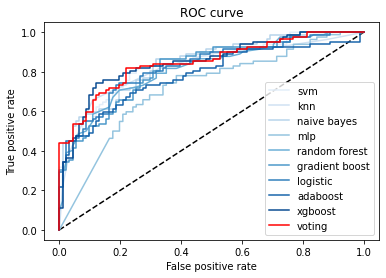

In [17]:
plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), 'voting')

In [18]:
base_learners = get_models()

In [19]:
meta_learner = GradientBoostingClassifier(
   n_estimators=128,
   loss="exponential",
   max_features=4,
   max_depth=3,
   subsample=0.5,
   learning_rate=0.005, 
   random_state=seed
)

In [20]:
train_base_learners(base_learners, x_train, y_train)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.


{'random forest': array([0.07237513, 0.06200036, 0.04445395, 0.0509426 , 0.05141474,
        0.0454205 , 0.08053085, 0.05781409, 0.10820072, 0.05347902,
        0.07868684, 0.06135261, 0.09472812, 0.0468866 , 0.04541476,
        0.04629914]),
 'gradient boost': array([0.07743489, 0.05785279, 0.01815878, 0.02429884, 0.04939829,
        0.02094176, 0.09885597, 0.02826301, 0.3149959 , 0.00719196,
        0.11875747, 0.06761731, 0.06581314, 0.01584081, 0.01344497,
        0.0211341 ]),
 'adaboost': array([0.046875, 0.109375, 0.046875, 0.03125 , 0.046875, 0.015625,
        0.046875, 0.046875, 0.21875 , 0.046875, 0.078125, 0.09375 ,
        0.0625  , 0.03125 , 0.046875, 0.03125 ]),
 'xgboost': array([0.04611219, 0.06708208, 0.04962626, 0.05644031, 0.04641883,
        0.04140768, 0.05601015, 0.05183904, 0.169615  , 0.03518948,
        0.09924139, 0.05427925, 0.10095457, 0.03300514, 0.04760596,
        0.04517268], dtype=float32)}

In [21]:
P_base = predict_base_learners(base_learners, x_train)
P_test = predict_base_learners(base_learners, x_test)

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.


In [22]:
meta_learner.fit(P_base, y_train)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=128, random_state=0,
                           subsample=0.5)

In [23]:
P_pred, p = ensemble_predict(base_learners, meta_learner, x_test)
print("\nStacking ROC-AUC score: %.3f" % roc_auc_score(y_test, p))
print("Stacking ACC score: %.3f" % accuracy_score(y_test, np.float32(p > 0.5)))

Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Stacking ROC-AUC score: 0.799
Stacking ACC score: 0.757


In [24]:
c = 0
for k, v in base_learners.items():
    print("{} ROC-AUC score: %.3f".format(k) % roc_auc_score(y_test, P_pred[:, c]))
    print("{} ACC score: %.3f \n".format(k) % accuracy_score(y_test, np.float32(P_pred[:, c] > 0.5)))
    c = c + 1

svm ROC-AUC score: 0.837
svm ACC score: 0.775 

knn ROC-AUC score: 0.825
knn ACC score: 0.757 

naive bayes ROC-AUC score: 0.845
naive bayes ACC score: 0.734 

mlp ROC-AUC score: 0.721
mlp ACC score: 0.682 

random forest ROC-AUC score: 0.815
random forest ACC score: 0.734 

gradient boost ROC-AUC score: 0.821
gradient boost ACC score: 0.734 

logistic ROC-AUC score: 0.828
logistic ACC score: 0.746 

adaboost ROC-AUC score: 0.783
adaboost ACC score: 0.723 

xgboost ROC-AUC score: 0.849
xgboost ACC score: 0.769 



In [25]:
index = train_dataset[feature].index

## 5-fold validation

In [26]:
idx = list(index)
np.random.shuffle(idx)
X_ = X[idx]
y_ = y[idx]
cls_data_voting = train_dataset.copy().reset_index(drop=True)
cls_data_voting = cls_data_voting.iloc[idx]
cls_data_voting = cls_data_voting.reset_index(drop=True)
cv_scores_vote = []
feature_importances_list = []
prob = pd.DataFrame(columns=base_learners.keys(), dtype='float32')
for i, (train_idx, test_idx) in enumerate(KFold(5).split(X_)):
    fold_x_train, fold_y_train = X_[train_idx, :], y_[train_idx]
    fold_x_test, fold_y_test = X_[test_idx, :], y_[test_idx]
    
    base_learners = get_models()

    feature_importances = train_base_learners(base_learners, fold_x_train, fold_y_train)
    P_test = predict_base_learners(base_learners, fold_x_test)
    for i, model_name in zip(range(len(base_learners.keys())), base_learners.keys()):
        cls_data_voting.loc[test_idx, model_name] = P_test[:, i]
    
    p_vote = P_test.mean(axis=1)
    fold_y_pred = np.float32(p_vote > 0.5)
    
    acc = accuracy_score(fold_y_test, fold_y_pred)
    recall = recall_score(fold_y_test, fold_y_pred)
    cm = confusion_matrix(fold_y_test, fold_y_pred)
    roc = roc_auc_score(fold_y_test, p_vote)
    
    cls_data_voting.loc[test_idx, 'pred'] = fold_y_pred
    cls_data_voting.loc[test_idx, 'prob'] = p_vote
    prob = pd.concat([prob, pd.DataFrame(P_test, columns=base_learners.keys())])

    print("\nEnsemble ROC-AUC score: %.3f" % roc)
    print("Ensemble ACC score: %.3f" % acc)
    
    cv_scores_vote.append({'acc': acc, 'recall': recall, 'confusion_matrix': cm, 'roc_auc_score': roc})
    feature_importances_list.append(feature_importances)

Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predictions.
svm...knn...naive bayes...mlp...random forest...gradient boost...logistic...adaboost...xgboost...done.

Ensemble ROC-AUC score: 0.853
Ensemble ACC score: 0.757
Fitting models
svm...no sample_weight
no feature importances
knn...no sample_weight
no feature importances
naive bayes...no sample_weight
no feature importances
mlp...no sample_weight
no feature importances
random forest...no sample_weight
gradient boost...no sample_weight
logistic...no sample_weight
no feature importances
adaboost...no sample_weight
xgboost...no sample_weight
done.
Generating base learner predict

In [27]:
feature_stacking = pd.DataFrame(pd.DataFrame(feature_importances_list).sum().to_dict(), index=feature)
feature_stacking['sum'] = feature_stacking.sum(axis=1)
feature_stacking = feature_stacking.sort_values(by='sum')

In [28]:
# feature_stacking.to_csv('csv/feature_importance/filled_softimpute.csv')

In [29]:
pd.DataFrame(cv_scores_vote)

,acc,recall,confusion_matrix,roc_auc_score
0,0.757225,0.768293,"[[68, 23], [19, 63]]",0.852854
1,0.768786,0.779221,"[[73, 23], [17, 60]]",0.872835
2,0.739884,0.709677,"[[62, 18], [27, 66]]",0.790860
3,0.773256,0.747253,"[[65, 16], [23, 68]]",0.848732
4,0.726744,0.695122,"[[68, 22], [25, 57]]",0.811653


In [30]:
np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])

array([[336, 102],
       [111, 314]], dtype=int64)

Text(33.0, 0.5, 'True labels')

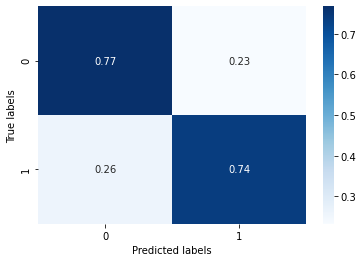

In [31]:
cm = np.sum(pd.DataFrame(cv_scores_vote)['confusion_matrix'])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Blues', annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [32]:
cv_results['voting'] = pd.DataFrame(cv_scores_vote)['acc']
cv_results

,svm,knn,naive bayes,mlp,random forest,gradient boost,logistic,adaboost,xgboost,voting
0,0.751445,0.757225,0.745665,0.734104,0.739884,0.728324,0.739884,0.710983,0.722543,0.757225
1,0.710983,0.751445,0.734104,0.699422,0.728324,0.751445,0.699422,0.699422,0.734104,0.768786
2,0.751445,0.722543,0.728324,0.630058,0.734104,0.757225,0.768786,0.710983,0.728324,0.739884
3,0.715116,0.715116,0.732558,0.686047,0.750000,0.720930,0.726744,0.726744,0.720930,0.773256
4,0.784884,0.755814,0.761628,0.686047,0.779070,0.802326,0.779070,0.767442,0.779070,0.726744


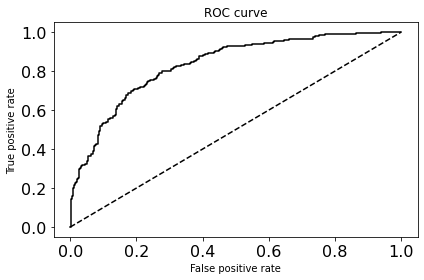

In [33]:
fpr, tpr, _ = roc_curve(cls_data_voting['severity'], cls_data_voting['prob'])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Voting', c='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
#plt.legend()
plt.tick_params(labelsize=16)
plt.tight_layout()
#plt.savefig('fig/filled_knn_6.eps',format='eps')
#plt.savefig('fig/filled_knn_6.png', format='png')

In [34]:
thres = 0.50

In [35]:
acc = accuracy_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
recall = recall_score(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
cm = confusion_matrix(cls_data_voting['severity'], cls_data_voting['prob'] > thres)
roc = roc_auc_score(cls_data_voting['severity'], cls_data_voting['prob'])
sensitivity, specificity = sensitivity_specificity(cm)

print('roc auc score: \t{}'.format(roc))
print('accuarcy: \t{}'.format(acc))
print('recall: \t{}'.format(recall))
print('sensitivity: \t{}'.format(sensitivity))
print('specificity: \t{}'.format(specificity))
print('confusion matrix: \n{}'.format(cm))

roc auc score: 	0.8330593607305936
accuarcy: 	0.7531865585168018
recall: 	0.7388235294117647
sensitivity: 	0.7388235294117647
specificity: 	0.7671232876712328
confusion matrix: 
[[336 102]
 [111 314]]


In [36]:
results = pd.DataFrame(index=base_learners.keys(), columns=['roc', 'acc', 'recall', 'cm', 'sensitivity', 'specificity'], dtype='object')
for k in base_learners.keys():
    acc = accuracy_score(cls_data_voting['severity'], prob[k] > thres)
    recall = recall_score(cls_data_voting['severity'], prob[k] > thres)
    cm = confusion_matrix(cls_data_voting['severity'], prob[k] > thres)
    roc = roc_auc_score(cls_data_voting['severity'], prob[k])
    sensitivity, specificity = sensitivity_specificity(cm)
    results.loc[k, :] = [roc, acc, recall, cm, sensitivity, specificity]

C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.array(value)
C:\Users\71774\AppData\Roaming\Python\Python37\site-packages\pandas\core\internals\blocks.py:902: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

In [37]:
# results.to_csv('./csv/cross_validation_trainSet/filled_softimpute.csv')

[Text(0.5, 0, 'Classifcation Methods'),
 Text(0, 0.5, 'Accuracy'),
 Text(0.5, 1.0, '5-Fold Cross Validation Accuracy')]

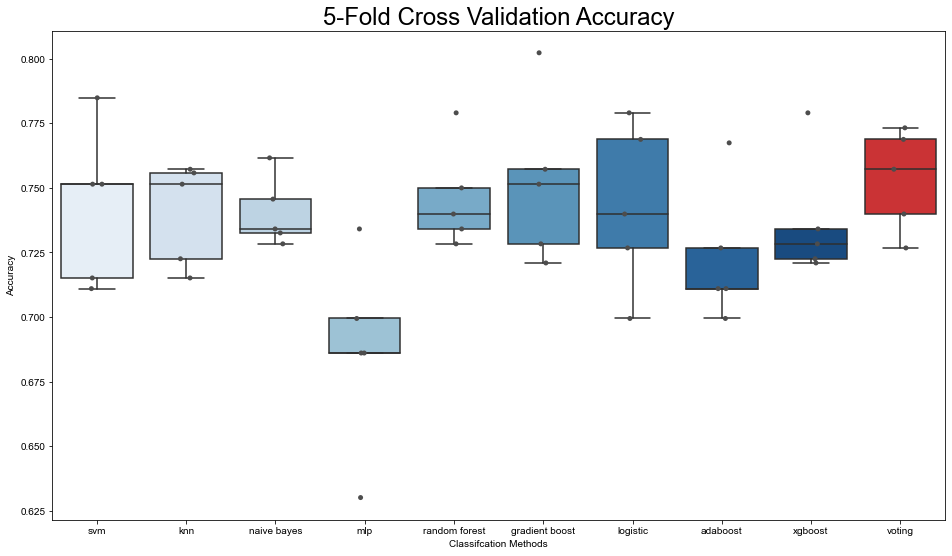

In [38]:
plt.subplots(figsize=(16, 9))
sns.set(style="ticks")
sns.set(font_scale=2.0)
colors = sns.color_palette("Blues", len(base_learners.keys()))
colors.append((0.8901960784313725, 0.10196078431372549, 0.10980392156862745))
dx = sns.boxplot(data=cv_results, palette=colors, boxprops=dict(alpha=1.0),showfliers = False)
dx = sns.stripplot(data=cv_results,
                   jitter=True,
                   color=".3",
                   dodge=True,
                   marker='o', 
                   alpha=1.0)
dx.set(xlabel='Classifcation Methods',ylabel='Accuracy', title='5-Fold Cross Validation Accuracy')

In [39]:
# P_test = predict_base_learners(base_learners, np.array(test_dataset_filled_softimpute[feature]))
# test_dataset_filled_softimpute['prediction_clinical'] = P_test.mean(axis=1)

In [40]:
# test_dataset_filled_softimpute.to_csv('./csv/prediction_testSet/filled_softimpute.txt')